<a href="https://colab.research.google.com/github/manzoorturakhel/Dementia_Prediction/blob/main/VGG16_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
path=drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
files.extractall('')
files.close()

In [3]:
# importing important libraries

import torch
from torch import nn

import torchvision
from torchvision import transforms,datasets, models
from torchvision.transforms import ToTensor, v2

from torch.utils.data import DataLoader, random_split, Dataset

from imblearn.over_sampling import SMOTE




import matplotlib.pyplot  as plt

from tqdm.auto import tqdm

import os

from pathlib import Path

In [4]:
# checking if gpu is available

if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
# elif torch.backends.mps.is_available():
#     device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cuda


In [5]:
# lets prepare our data for training and testing and do some EDA
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader
import torch
root_dir= "Alzheimer_s Dataset"
train_dir = os.path.join(root_dir,'train')

simple_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),
])

transform = v2.Compose([


        v2.ColorJitter(brightness=0.5),  # Brightness adjustment


        v2.RandomAffine(degrees=0, scale=(0.98, 1.2)), # Zooming


        v2.Pad(padding=5, fill=0),  # Filling (padding with zeros)

    v2.RandomHorizontalFlip(p=0.4),  # Flipping
    v2.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    v2.Resize((176, 176)),  # Rescaling
    v2.CenterCrop(size=(166,166)),
    # v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),



])
simple_train_data =  datasets.ImageFolder(train_dir,transform=simple_transform)
# now that we have sat the train and test directories we will prepare it to make it as a dataset using datasets.ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=transform)

train_size = int(0.7 * len(train_data))
val_size = int(0.15 * len(train_data))
test_size = len(train_data) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(train_data, [train_size, val_size, test_size])





# let check the data now
print(len(train_data.samples)) #

class_names = train_data.classes
class_idx = train_data.class_to_idx


batch_size = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





6400


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:

 root_dir= "Alzheimer_s Dataset"
 for dirpath, dirnames, filenames in os.walk(root_dir):
  print(f" directory name:{dirnames} files lens:{len(filenames)}")



 directory name:['train'] files lens:1
 directory name:['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented'] files lens:1
 directory name:[] files lens:896
 directory name:[] files lens:3200
 directory name:[] files lens:64
 directory name:[] files lens:2240


{'MildD': 896, 'ModerateD': 64, 'VeryMildD': 2240, 'NonD': 3200}


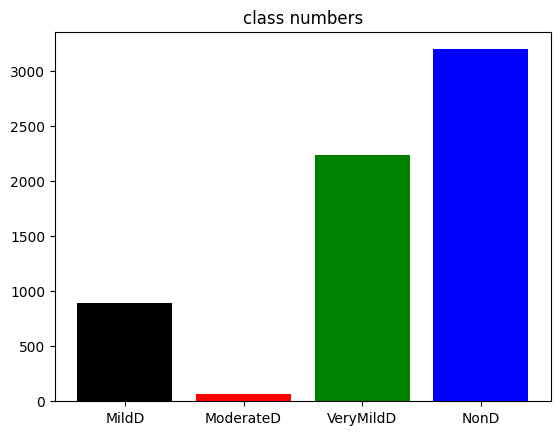

In [7]:
# befor applying SMOTE imbalance classes
MildDemented = os.path.join(train_dir,'MildDemented')
ModerateDemented= os.path.join(train_dir,'ModerateDemented')
VeryMildDemented=os.path.join(train_dir,'VeryMildDemented')
NonDemented=os.path.join(train_dir,'NonDemented')


num_of_classes_in_training =  {
    'MildD':len(os.listdir(MildDemented)),
    'ModerateD':len(os.listdir(ModerateDemented)),
    'VeryMildD':len(os.listdir(VeryMildDemented)),
    'NonD':len(os.listdir(NonDemented))
}
print(num_of_classes_in_training)
plt.bar(num_of_classes_in_training.keys(),num_of_classes_in_training.values(),color=['black','red','green','blue']);
plt.title('class numbers');

In [8]:
print(len(train_loader.dataset))
print(type(train_data.classes))

4480
<class 'list'>


In [9]:
# applying SMOTE to balance classes and see whether it improves the performance

X = []
y = []
for img, label in train_data:
    X.append(img.numpy().flatten())  # Flatten the image
    y.append(label)

X = np.array(X)
y = np.array(y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to PyTorch tensors
X_resampled = torch.from_numpy(X_resampled).float().view(-1, 3, 166, 166)  # Reshape back to image format
y_resampled = torch.from_numpy(y_resampled).long()

# Create a new TensorDataset
balanced_dataset = TensorDataset(X_resampled, y_resampled)




class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.tensor_dataset[index]

        # Convert tensor to PIL Image for transforms
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.tensor_dataset)

# # Create the transformed dataset
transformed_balanced_dataset = TransformedTensorDataset(balanced_dataset, transform=transform)

# print(len(transformed_balanced_dataset))


In [10]:
print(type(balanced_dataset.tensors),type(train_data.imgs))

<class 'tuple'> <class 'list'>


In [11]:
print(len(transformed_balanced_dataset))

# splitting the new data between train,validation and test


train_size = int(0.7 * len(transformed_balanced_dataset))
val_size = int(0.15 * len(transformed_balanced_dataset))
test_size = len(transformed_balanced_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(transformed_balanced_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





# let check the data now
print(len(transformed_balanced_dataset.tensor_dataset))

class_names = train_data.classes
class_idx = train_data.class_to_idx


12800
12800


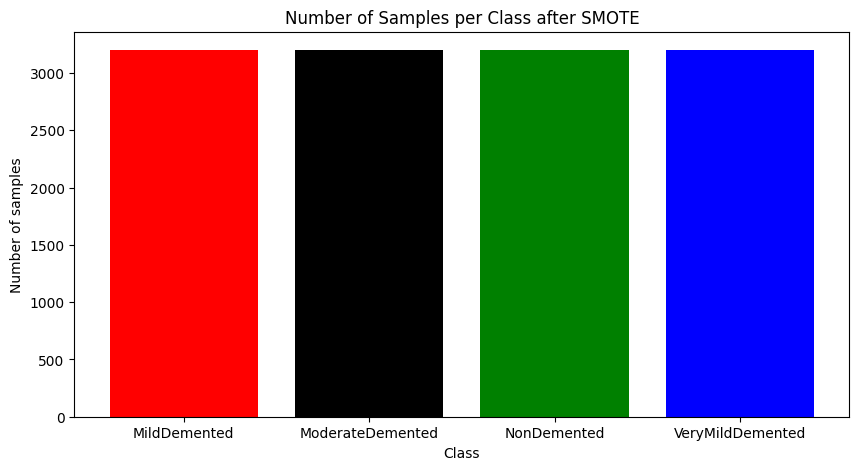

In [12]:
# after applying smote


unique, counts = np.unique(y_resampled, return_counts=True)

unique,counts
# new number of sample per class object
new_number_of_classes={}


for i in range(len(unique)):
  new_number_of_classes[class_names[i]] = counts[i]


new_number_of_classes

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(new_number_of_classes.keys(), new_number_of_classes.values(), color=['red','black','green','blue'])
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of Samples per Class after SMOTE')
plt.show()


In [13]:
print(type(train_data.imgs))

<class 'list'>


torch.Size([1, 208, 176])


(-0.5, 165.5, 165.5, -0.5)

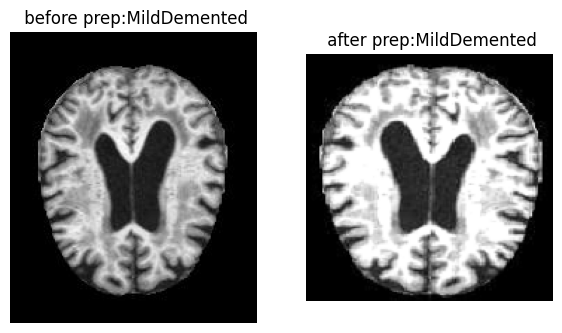

In [14]:
# let visualize images after and before data augmentation

plt.figure(figsize=(7,6))

image,label  = simple_train_data[5]

# augmented data
image1,label1 = train_data[5]

print(image.shape)

plt.subplot(1,2,1)
plt.imshow(image.permute(1, 2, 0),cmap='gray');
plt.title(f" before prep:{class_names[label]}")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(image1.permute(1, 2, 0),cmap='gray');
plt.title(f" after prep:{class_names[label1]}")
plt.axis(False)

In [15]:
# let visualize some random images from the dataset
def displayRandomImage(data,nrows:int=4,ncols:int=4):
  """
  data will be from train1 and train2 to see the difference
  nrows are number of rows and by default it will be 4 unless specified
  ncols are number of cols and by default it will be 4 unless specified
  """
  plt.figure(figsize=(9,9))
  torch.manual_seed(42)

  for i in range(1,nrows*ncols+1):

    random_idx = torch.randint(0,len(data),size=[1]).item()
    image,label = data[random_idx]
    plt.subplot(nrows,ncols,i)
    plt.imshow(image.permute(1, 2, 0),cmap='gray');
    plt.title(class_names[label]);
    plt.axis(False);





images before preprocessing.....



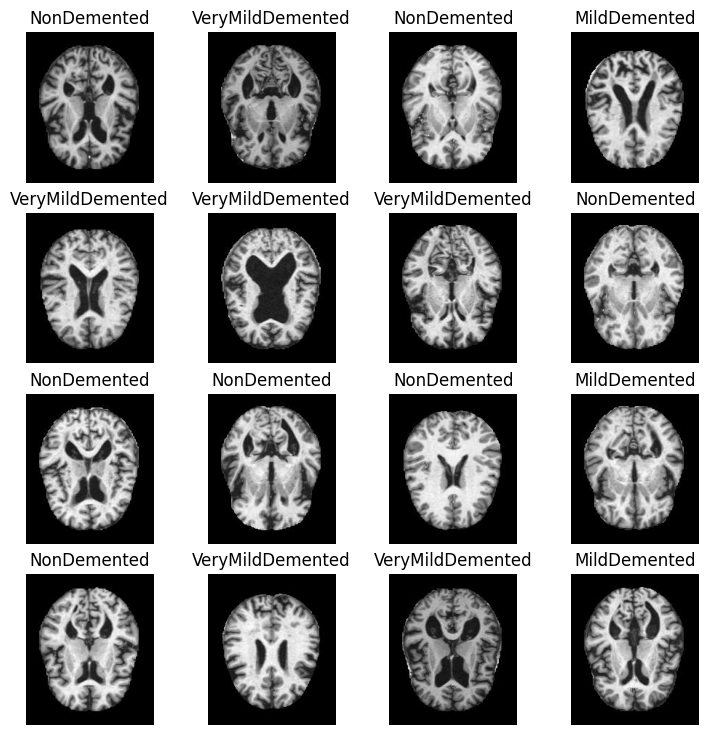

In [16]:
print("images before preprocessing.....\n")

displayRandomImage(simple_train_data)

images after preprocessing.....



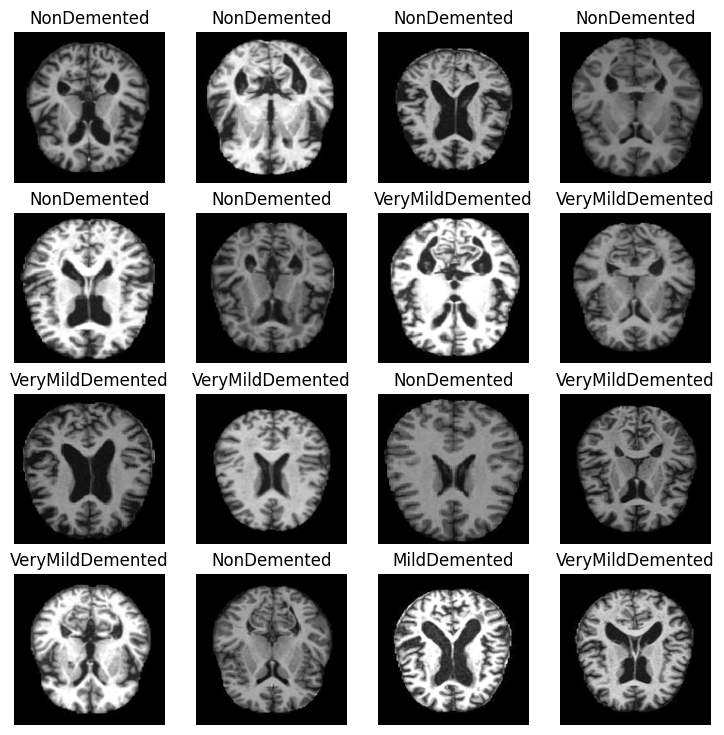

In [17]:
print("images after preprocessing.....\n")

displayRandomImage(train_data)

In [18]:
# pip install torchsampler
weights = torchvision.models.VGG16_BN_Weights.DEFAULT    # .DEFAULT = best available weights
model1 = torchvision.models.vgg16_bn(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 78.1MB/s]


In [19]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo



In [20]:
# model1 = customCNN(input_shape=1,filters=32,output_shape=4).to(device)
from torchinfo import summary
summary(model=model1,
        input_size=(50, 3, 166, 166), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)



Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [50, 3, 166, 166]    [50, 1000]           --                   True
├─Sequential (features)                  [50, 3, 166, 166]    [50, 512, 5, 5]      --                   True
│    └─Conv2d (0)                        [50, 3, 166, 166]    [50, 64, 166, 166]   1,792                True
│    └─BatchNorm2d (1)                   [50, 64, 166, 166]   [50, 64, 166, 166]   128                  True
│    └─ReLU (2)                          [50, 64, 166, 166]   [50, 64, 166, 166]   --                   --
│    └─Conv2d (3)                        [50, 64, 166, 166]   [50, 64, 166, 166]   36,928               True
│    └─BatchNorm2d (4)                   [50, 64, 166, 166]   [50, 64, 166, 166]   128                  True
│    └─ReLU (5)                          [50, 64, 166, 166]   [50, 64, 166, 166]   --                   --
│    └─MaxPool2d (

In [21]:
model1.features[43]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [22]:
# unfreezing all layers
for param in model1.parameters():
    param.requires_grad = True




# for layer in [model1.features[34],model1.features[35],model1.features[36],model1.features[37],model1.features[38],model1.features[39],model1.features[40],model1.features[41],model1.features[42],model1.features[43],model1.avgpool]:
#     for param in layer.parameters():
#         param.requires_grad = True

# Verifying
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(f"Unfrozen layer: {name}")
model1.classifier = torch.nn.Sequential(
    nn.Linear(in_features=25088, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=150, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),

   nn.Linear(in_features=150, out_features=4, bias=True),



    ).to(device)


Unfrozen layer: features.0.weight
Unfrozen layer: features.0.bias
Unfrozen layer: features.1.weight
Unfrozen layer: features.1.bias
Unfrozen layer: features.3.weight
Unfrozen layer: features.3.bias
Unfrozen layer: features.4.weight
Unfrozen layer: features.4.bias
Unfrozen layer: features.7.weight
Unfrozen layer: features.7.bias
Unfrozen layer: features.8.weight
Unfrozen layer: features.8.bias
Unfrozen layer: features.10.weight
Unfrozen layer: features.10.bias
Unfrozen layer: features.11.weight
Unfrozen layer: features.11.bias
Unfrozen layer: features.14.weight
Unfrozen layer: features.14.bias
Unfrozen layer: features.15.weight
Unfrozen layer: features.15.bias
Unfrozen layer: features.17.weight
Unfrozen layer: features.17.bias
Unfrozen layer: features.18.weight
Unfrozen layer: features.18.bias
Unfrozen layer: features.20.weight
Unfrozen layer: features.20.bias
Unfrozen layer: features.21.weight
Unfrozen layer: features.21.bias
Unfrozen layer: features.24.weight
Unfrozen layer: features.

In [23]:
summary(model=model1,
        input_size=(50, 3, 150, 150), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [50, 3, 150, 150]    [50, 4]              --                   True
├─Sequential (features)                  [50, 3, 150, 150]    [50, 512, 4, 4]      --                   True
│    └─Conv2d (0)                        [50, 3, 150, 150]    [50, 64, 150, 150]   1,792                True
│    └─BatchNorm2d (1)                   [50, 64, 150, 150]   [50, 64, 150, 150]   128                  True
│    └─ReLU (2)                          [50, 64, 150, 150]   [50, 64, 150, 150]   --                   --
│    └─Conv2d (3)                        [50, 64, 150, 150]   [50, 64, 150, 150]   36,928               True
│    └─BatchNorm2d (4)                   [50, 64, 150, 150]   [50, 64, 150, 150]   128                  True
│    └─ReLU (5)                          [50, 64, 150, 150]   [50, 64, 150, 150]   --                   --
│    └─MaxPool2d (

In [24]:
rand_image_tensor = torch.randn(size=(3, 150, 150))
rand_image_tensor=rand_image_tensor.to(device)

In [25]:
# now trying to see the flatten shape
model1(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0191,  0.0217, -0.1603, -0.0443]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),lr=0.001)


# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,15], gamma=0.001)

In [27]:
def train_benchmark(start:float, end:float, device:torch.device = None):
    """
    start: is the start time of the training benchmark

    end: is the end time of the training benchmark

    device: is the device which is going to run the training benchmark either 'cpu' or 'gpu' in case of mac m1 'mps'
    """
    print(f" training benchmark on {device} took {(end-start):.3f} seconds")


In [28]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
train_loss_values=[]
train_acc_values= []

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):



    # """Performs a training step with the model trying to learn on data_loader."""
  global train_loss_values
  global train_acc_values
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

    # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
      X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
      y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() # accumulate train loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

        # 3. Optimizer zero grad
      optimizer.zero_grad()

        # 4. Loss backward
      loss.backward()

        # 5. Optimizer step (update the model's parameters once *per batch*)
      optimizer.step()
      # scheduler.step(train_loss)

    # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_loss_values.append(train_loss)
  train_acc_values.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")



In [30]:
validation_loss_values=[]
validation_acc_values=[]
def valid_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    # """Performs a validation loop step on model going over data_loader."""

  global validation_loss_values
  global validation_acc_values
  valid_loss, valid_acc = 0, 0

    # Put the model in eval mode
  model.eval()

    # Turn on inference mode context manager
  with torch.inference_mode():

    for X, y in data_loader:

            # Send the data to the target device
      X, y = X.to(device), y.to(device)

            # 1. Forward pass (outputs raw logits)
      valid_pred = model(X)

            # 2. Calculate the loss and accuracy
      valid_loss += loss_fn(valid_pred, y)
      valid_acc += accuracy_fn(y_true=y, y_pred=valid_pred.argmax(dim=1))  # go from logits -> prediction labels

        # Adjust metrics and print out
    valid_loss /= len(data_loader)
    valid_acc /= len(data_loader)
    validation_loss_values.append(valid_loss)
    validation_acc_values.append(valid_acc)
    print(f"valid loss: {valid_loss:.5f} | valid acc: {valid_acc:.2f}%\n")


In [31]:
from timeit import default_timer as timer

start = timer()
EPOCHS= 30

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n......")

  train_step(model1,train_loader,loss_fn,optimizer,accuracy_fn,device)
  valid_step(model1,val_loader,loss_fn,accuracy_fn,device)



end =timer()
train_benchmark(start=start,end=end,device=str(next(model1.parameters()).device))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 
......
Train loss: 1.18563 | Train acc: 39.40%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


valid loss: 0.99893 | valid acc: 48.62%

Epoch: 1 
......
Train loss: 0.90951 | Train acc: 49.23%
valid loss: 0.85434 | valid acc: 49.97%

Epoch: 2 
......
Train loss: 0.86264 | Train acc: 50.60%
valid loss: 0.89799 | valid acc: 49.90%

Epoch: 3 
......
Train loss: 0.86237 | Train acc: 52.70%
valid loss: 0.81604 | valid acc: 57.97%

Epoch: 4 
......
Train loss: 0.75154 | Train acc: 62.94%
valid loss: 0.65120 | valid acc: 68.72%

Epoch: 5 
......
Train loss: 0.68971 | Train acc: 67.13%
valid loss: 0.62484 | valid acc: 72.21%

Epoch: 6 
......
Train loss: 0.59644 | Train acc: 72.27%
valid loss: 0.75924 | valid acc: 65.38%

Epoch: 7 
......
Train loss: 0.54962 | Train acc: 75.12%
valid loss: 0.54417 | valid acc: 75.44%

Epoch: 8 
......
Train loss: 0.55005 | Train acc: 75.06%
valid loss: 0.67790 | valid acc: 68.51%

Epoch: 9 
......
Train loss: 0.48372 | Train acc: 77.74%
valid loss: 0.56293 | valid acc: 75.05%

Epoch: 10 
......
Train loss: 0.44762 | Train acc: 79.90%
valid loss: 0.42389

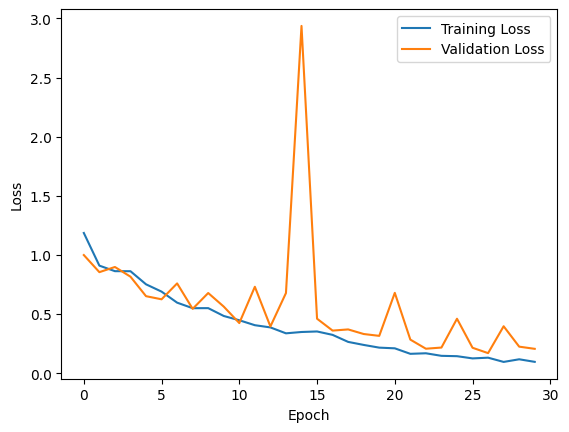

In [32]:
# let's plot the train and test loss functions
len(train_acc_values)
epochs = list(range(0,len(train_loss_values)))

# Plot the losses
plt.plot(epochs, torch.tensor(train_loss_values).cpu(), label='Training Loss')
plt.plot(epochs, torch.tensor(validation_loss_values).cpu(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

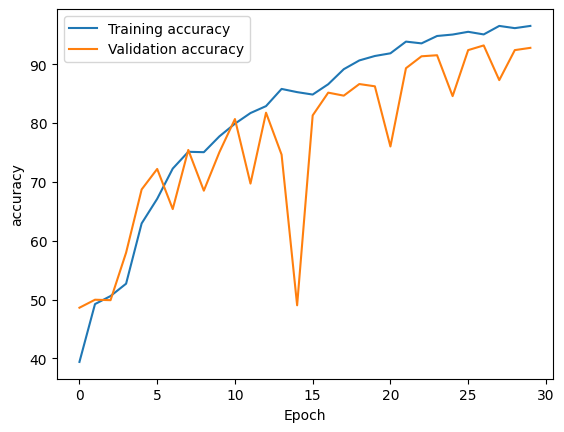

In [33]:
# accuracylen(train_acc_values)
epochs = list(range(0,len(train_acc_values)))

# Plot the losses
plt.plot(epochs, torch.tensor(train_acc_values).cpu(), label='Training accuracy')
plt.plot(epochs, torch.tensor(validation_acc_values).cpu(), label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [34]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [35]:
import random
# random.seed(42)
print(len(test_dataset))
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=1920):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

1920


torch.Size([3, 166, 166])

In [36]:
pred_probs = make_predictions(model=model1,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.3217e-03, 2.8985e-06, 3.1937e-03, 9.9148e-01]])

In [37]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 3, 2,  ..., 0, 2, 1])

In [38]:
array_test_labels =[]

for item in test_labels:

  array_test_labels.append(item.item())

# array_test_labels


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay
comparison= {
    'predicted_labels':pred_classes,
    'true labels':array_test_labels
}

import pandas as pd

df= pd.DataFrame(data=comparison)

df.head(50)

accuracy_score(test_labels,pred_classes)*100

91.71875

In [40]:
df.head(20)

,predicted_labels,true labels
0,1,1
1,3,3
2,2,2
3,3,2
4,0,0
5,0,0
6,0,0
7,2,2
8,3,2
9,2,2


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       468
           1       1.00      1.00      1.00       473
           2       0.79      0.97      0.87       414
           3       0.93      0.78      0.85       565

    accuracy                           0.92      1920
   macro avg       0.92      0.93      0.92      1920
weighted avg       0.92      0.92      0.92      1920

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


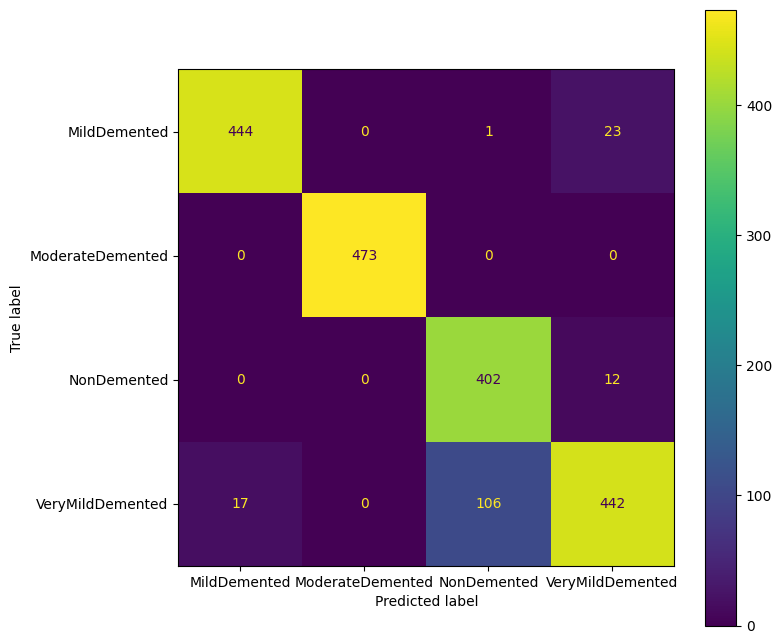

In [41]:
cm = confusion_matrix(pred_classes,array_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
print(classification_report(pred_classes,array_test_labels))
print(class_idx)

In [42]:

# Create model dictory path
MODEL_PATH = Path(f"{path}/models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vgg16_bn_v3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: None/models/vgg16_bn_v3.pth
